<a href="https://colab.research.google.com/github/00marco/data_science_dev_env_template/blob/main/Indeed_Jobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
!pip install jupyter-black duckdb bertopic gensim

In [3]:
%load_ext jupyter_black

# Load dataset

In [4]:
import os

json_datasets = os.listdir("/content/drive/MyDrive/Datasets/jobs")
json_datasets

['dataset_indeed-scraper_2025-04-08_04-15-04-847.json',
 'dataset_indeed-scraper_2025-05-01_04-36-26-112.json',
 'dataset_indeed-scraper_2025-06-01_04-36-04-960.json',
 'dataset_indeed-scraper_2025-07-01_04-35-47-841.json',
 'dataset_indeed-scraper_2025-08-01_04-40-22-916.json',
 'dataset_indeed-scraper_2025-08-15_12-43-26-626.json',
 'dataset_indeed-scraper_2025-08-18_05-46-59-735.json']

# Util functions

In [5]:
import re


def extract_salary_info(df):
    """
    Extracts min, max, and calculates mean salary from a DataFrame's 'salary' column.

    Args:
        df (pd.DataFrame): The input DataFrame with a 'salary' column.

    Returns:
        pd.DataFrame: A new DataFrame with 'mean_salary', 'min_salary', and 'max_salary'.
    """
    # Extract numerical values from the 'salary' column
    salary_ranges = (
        df["salary"].astype(str).str.findall(r"\d{1,3}(?:,\d{3})*(?:\.\d+)?")
    )

    # Convert extracted values to numeric, handling potential errors
    def safe_numeric(value_list):
        numeric_values = []
        for val in value_list:
            try:
                numeric_values.append(float(val.replace(",", "")))
            except ValueError:
                pass
        return numeric_values

    numeric_salaries = salary_ranges.apply(safe_numeric)

    # Calculate min, max, and mean, handling cases with no valid salary data
    df["min_salary"] = numeric_salaries.apply(lambda x: min(x) if x else None)
    df["max_salary"] = numeric_salaries.apply(lambda x: max(x) if x else None)
    df["mean_salary"] = numeric_salaries.apply(lambda x: sum(x) / len(x) if x else None)

    return df


def extract_company_info(df):
    df["company_size_min"] = df["companyInfo"].str["companySize"].str["min"]
    df["company_size_max"] = df["companyInfo"].str["companySize"].str["max"]

    df["company_url"] = df["companyInfo"].str["url"]
    df["company_indeedUrl"] = df["companyInfo"].str["indeedUrl"]
    # df["company_url"] = (
    #     df["url"].replace("", None).fillna(df["companyInfo"].str["indeedUrl"])
    # )
    return df

In [6]:
import numpy as np


def label_postingDate(df):
    df["postingDateParsed"] = pd.to_datetime(df["postingDateParsed"]).dt.tz_convert(
        None
    )
    df["monthPosted"] = df["postingDateParsed"].dt.strftime("%y-%m")
    df["latestScrapedDate"] = np.max(
        pd.to_datetime(df["scrapedAt"]).dt.tz_convert(None)
    )

    df["<30d"] = (df["latestScrapedDate"] - df["postingDateParsed"]).dt.days <= 30
    df["<60d"] = (df["latestScrapedDate"] - df["postingDateParsed"]).dt.days <= 60
    df["<90d"] = (df["latestScrapedDate"] - df["postingDateParsed"]).dt.days <= 90
    return df


def drop_dirty_data(df):
    return df.loc[pd.notnull(df["postingDateParsed"])]


def get_search_term(df):
    df["searchTerm"] = df["searchInput"].str["position"]
    return df

In [7]:
combined_df = pd.concat(
    [
        pd.read_json(os.path.join("/content/drive/MyDrive/Datasets/jobs", x))
        for x in json_datasets
    ]
)
combined_df["country"] = combined_df["searchInput"].str["country"]
combined_df

,salary,postedAt,externalApplyLink,positionName,jobType,company,location,rating,reviewsCount,urlInput,url,id,scrapedAt,postingDateParsed,description,descriptionHTML,searchInput,isExpired,companyInfo,country
0,None,Just posted,None,BI Developer,[Full-time],People Matter PH,Taguig,0.0,0,NaN,https://ph.indeed.com/viewjob?jk=d17ed418472b107e,d17ed418472b107e,2025-04-08T04:09:36.739Z,2025-04-08T01:12:13.755Z,This is a full-time role for a BI Developer (O...,<p>This is a full-time role for a BI Developer...,"{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://ph.indeed.com/cmp/Peopl...,PH
1,None,Just posted,https://ph.indeed.com/applystart?jk=aff69509c9...,Software Engineer,[Full-time],Finastra USA Corporation,Pasig Central Post Office 1600 P00,3.4,310,NaN,https://ph.indeed.com/viewjob?jk=aff69509c9cfe3b6,aff69509c9cfe3b6,2025-04-08T04:09:56.428Z,2025-04-07T16:35:16.115Z,Responsibilities:\nJob Description\nWe’re look...,<b>Responsibilities:</b><br>\nJob Description\...,"{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://ph.indeed.com/cmp/Finas...,PH
2,None,Just posted,None,Jr. PHP Developer (LAMP Stack),[Full-time],H2 Software Consulting Services Inc.,Pasig,3.3,21,NaN,https://ph.indeed.com/viewjob?jk=850eb6521c2b46e6,850eb6521c2b46e6,2025-04-08T04:09:57.638Z,2025-04-08T01:42:58.534Z,We are seeking a motivated and enthusiastic *J...,<p>We are seeking a motivated and enthusiastic...,"{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://ph.indeed.com/cmp/H2-So...,PH
3,None,Just posted,https://ph.indeed.com/applystart?jk=1f90faf828...,Software Development Engineer,[Full-time],Accenture,Mandaluyong,4.0,27672,NaN,https://ph.indeed.com/viewjob?jk=1f90faf828ed5180,1f90faf828ed5180,2025-04-08T04:09:56.248Z,2025-04-07T16:45:53.444Z,"Analyze, design, code and test multiple compon...","Analyze, design, code and test multiple compon...","{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://ph.indeed.com/cmp/Accen...,PH
4,"PHP 80,000 - PHP 140,000 a month",Just posted,None,Full Stack Developer,[Full-time],My Biz Niche,Philippines,4.0,4,NaN,https://ph.indeed.com/viewjob?jk=f25208784d712558,f25208784d712558,2025-04-08T04:09:53.860Z,2025-04-07T22:08:32.327Z,_Web Services Department | Full-Time | Remote_...,<p><i>Web Services Department | Full-Time | Re...,"{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://ph.indeed.com/cmp/My-Bi...,PH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,None,20 days ago,https://au.indeed.com/applystart?jk=1e51264df2...,Senior Software Engineer,[Full-time],Carbiz Rentals,Australia,0.0,0,NaN,https://au.indeed.com/viewjob?jk=1e51264df2b8d105,1e51264df2b8d105,2025-08-18T05:46:51.909Z,2025-07-29T00:33:30.058Z,Are you passionate about turning cutting-edge ...,<div><div><p><b>Are you passionate about turni...,"{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://au.indeed.com/cmp/Carbi...,AU
374,None,20 days ago,https://au.indeed.com/applystart?jk=27bb3bad91...,Senior Frontend Engineer - CRO,"[Permanent, Full-time]",Luxury Escapes,Sydney NSW 2000,4.4,7,NaN,https://au.indeed.com/viewjob?jk=27bb3bad915a3fa0,27bb3bad915a3fa0,2025-08-18T05:46:56.484Z,2025-07-28T09:47:02.343Z,Be part of the team transforming global travel...,<div><p><b>Be part of the team transforming gl...,"{'position': 'software engineer', 'country': '...",False,{'indeedUrl': 'https://au.indeed.com/cmp/Luxur...,AU
375,None,19 days ago,https://au.indeed.com/applystart?jk=e1a8c71f1c...,Senior Security Automation Engineer,"[Permanent, Full-time]",Coles Group,Hawthorn East VIC 3123,3.6,3952,NaN,https://au.indeed.com/viewjob?jk=e1a8c71f1c62f5c0,e1a8c71f1c62f5c0,2025-08-18T05:46:56.638Z,2025-07-29T10:34:36.292Z,We've been trusted to serve Aussie communities...,<div><div>We've been trusted to serve Aussie c...,"{'position': 'software engineer', 'country': '...",False

In [8]:
combined_df.iloc[0]["companyInfo"]

{'indeedUrl': 'https://ph.indeed.com/cmp/People-Matter-Ph',
 'url': None,
 'companyDescription': None,
 'rating': None,
 'reviewCount': None,
 'companyLogo': None}

# Create jobs table

In [9]:
combined_df["searchInput"].tail(1).iloc[0]

{'position': 'software engineer', 'country': 'AU'}

In [26]:
pd.set_option("display.max_columns", None)
df = (
    combined_df.copy()
    .pipe(extract_salary_info)
    .pipe(extract_company_info)
    .pipe(label_postingDate)
    .pipe(drop_dirty_data)
    .pipe(get_search_term)
)
display(df.head(1))
print("spacer")
df_jobs = df[
    [
        "positionName",
        "id",
        "min_salary",
        "max_salary",
        "postingDateParsed",
        "monthPosted",
        "scrapedAt",
        "latestScrapedDate",
        "company",
        # "company_url",
        "company_indeedUrl",
        # "company_size_min",
        # "company_size_max",
        # "rating",
        # "reviewsCount",
        "description",
        # "<30d",
        # "<60d",
        # "<90d",
        "searchTerm",
    ]
]
df_jobs["country"] = df["country"]
df_jobs

,salary,postedAt,externalApplyLink,positionName,jobType,company,location,rating,reviewsCount,urlInput,url,id,scrapedAt,postingDateParsed,description,descriptionHTML,searchInput,isExpired,companyInfo,country,min_salary,max_salary,mean_salary,company_size_min,company_size_max,company_url,company_indeedUrl,monthPosted,latestScrapedDate,<30d,<60d,<90d,searchTerm
0,None,Just posted,None,BI Developer,[Full-time],People Matter PH,Taguig,0.0,0,NaN,https://ph.indeed.com/viewjob?jk=d17ed418472b107e,d17ed418472b107e,2025-04-08T04:09:36.739Z,2025-04-08 01:12:13.755,This is a full-time role for a BI Developer (ONSITE) Early Dayshift at PeopleMatter PH.\n\nThe B...,<p>This is a full-time role for a BI Developer (ONSITE) Early Dayshift at PeopleMatter PH.</p><p...,"{'position': 'software engineer', 'country': 'PH'}",False,"{'indeedUrl': 'https://ph.indeed.com/cmp/People-Matter-Ph', 'url': None, 'companyDescription': N...",PH,NaN,NaN,NaN,NaN,NaN,None,https://ph.indeed.com/cmp/People-Matter-Ph,25-04,2025-08-18 05:46:56.638,False,False,False,software engineer


spacer


/tmp/ipython-input-1033017825.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jobs["country"] = df["country"]


,positionName,id,min_salary,max_salary,postingDateParsed,monthPosted,scrapedAt,latestScrapedDate,company,company_indeedUrl,description,searchTerm,country
0,BI Developer,d17ed418472b107e,NaN,NaN,2025-04-08 01:12:13.755,25-04,2025-04-08T04:09:36.739Z,2025-08-18 05:46:56.638,People Matter PH,https://ph.indeed.com/cmp/People-Matter-Ph,This is a full-time role for a BI Developer (ONSITE) Early Dayshift at PeopleMatter PH.\n\nThe B...,software engineer,PH
1,Software Engineer,aff69509c9cfe3b6,NaN,NaN,2025-04-07 16:35:16.115,25-04,2025-04-08T04:09:56.428Z,2025-08-18 05:46:56.638,Finastra USA Corporation,https://ph.indeed.com/cmp/Finastra,Responsibilities:\nJob Description\nWe’re looking for a software engineer with 3+ years of exper...,software engineer,PH
2,Jr. PHP Developer (LAMP Stack),850eb6521c2b46e6,NaN,NaN,2025-04-08 01:42:58.534,25-04,2025-04-08T04:09:57.638Z,2025-08-18 05:46:56.638,H2 Software Consulting Services Inc.,https://ph.indeed.com/cmp/H2-Software-Consulting-Services-Inc.-2,We are seeking a motivated and enthusiastic *Junior PHP Developer* to join our growing developme...,software engineer,PH
3,Software Development Engineer,1f90faf828ed5180,NaN,NaN,2025-04-07 16:45:53.444,25-04,2025-04-08T04:09:56.248Z,2025-08-18 05:46:56.638,Accenture,https://ph.indeed.com/cmp/Accenture,"Analyze, design, code and test multiple components of application code across one or more client...",software engineer,PH
4,Full Stack Developer,f25208784d712558,80000.0,140000.0,2025-04-07 22:08:32.327,25-04,2025-04-08T04:09:53.860Z,2025-08-18 05:46:56.638,My Biz Niche,https://ph.indeed.com/cmp/My-Biz-Niche,"_Web Services Department | Full-Time | Remote_\n\n*Ready to build fast, secure, and scalable web...",software engineer,PH
...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,Senior Software Engineer,1e51264df2b8d105,NaN,NaN,2025-07-29 00:33:30.058,25-07,2025-08-18T05:46:51.909Z,2025-08-18 05:46:56.638,Carbiz Rentals,https://au.indeed.com/cmp/Carbiz-Rentals,"Are you passionate about turning cutting-edge computer vision and AI research into delightful, r...",software engineer,AU
374,Senior Frontend Engineer - CRO,27bb3bad915a3fa0,NaN,NaN,2025-07-28 09:47:02.343,25-07,2025-08-18T05:46:56.484Z,2025-08-18 05:46:56.638,Luxury Escapes,https://au.indeed.com/cmp/Luxury-Escapes,Be part of the team transforming global travel experiences!\n\nLuxury Escapes is one of the worl...,software engineer,AU
375,Senior Security Automation Engineer,e1a8c71f1c62f5c0,NaN,NaN,2025-07-29 10:34:36.292,25-07,2025-08-18T05:46:56.638Z,2025-08-18 05:46:56.638,Coles Group,https://au.indeed.com/cmp/Coles-Group-4,We've been trusted to serve Aussie communities since 1914 and grown to become a top 30-listed on...,software engineer,AU
376,DevOps Engineer,d1889a764b2e2932,NaN,NaN,2025-07-28 13:33:06.693,25-07,2025-08-18T05:46:54.791Z,2025-08-18 05:46:56.638,Verra Mobility,https://au.indeed.com/cmp/Verra-Mobility,Verra Mobility is a global leader in smart mobility. We develop technology-driven solutions to m...,software engineer,AU


# Create company table

In [42]:
def get_company_view(df, keyword):
    return (
        df.loc[df["description"].str.lower().str.contains(keyword)]
        .groupby(["company", "company_indeedUrl"])
        .agg(
            {
                "positionName": "count",
                "company_url": "first",
                "<90d": "sum",
                "<60d": "sum",
                "<30d": "sum",
                "min_salary": "min",
                "max_salary": "max",
                "rating": "first",
                "reviewsCount": "first",
                "country": "first",
            }
        )
        .rename(
            columns={
                "positionName": "total_listings",
                "<30d": "listings_<30d",
                "<60d": "listings_<60d",
                "<90d": "listings_<90d",
                "min_salary": "lowest_company_offer",
                "max_salary": "highest_company_offer",
            }
        )
        .sort_values("total_listings", ascending=False)
        .reset_index()
    )

In [43]:
df_companies = get_company_view(df, "")
df_companies

,company,company_indeedUrl,total_listings,company_url,listings_<90d,listings_<60d,listings_<30d,lowest_company_offer,highest_company_offer,rating,reviewsCount,country
0,Questronix Corporation,https://ph.indeed.com/cmp/Questronix-Corporation,81,None,40,37,0,60000.0,80000.0,3.6,19,PH
1,Accenture,https://ph.indeed.com/cmp/Accenture,45,https://www.accenture.com,17,12,1,NaN,NaN,4.0,27672,PH
2,Octal Philippines Inc.,https://ph.indeed.com/cmp/Octal-Philippines-Inc.,40,None,17,9,0,NaN,NaN,0.0,0,PH
3,Rising Tide Digital Inc.,https://ph.indeed.com/cmp/Rising-Tide-Digital-Inc.,37,None,18,9,0,30000.0,150000.0,4.5,2,PH
4,CXC Philippines,https://ph.indeed.com/cmp/Cxc-Philippines,35,None,22,19,0,40000.0,250000.0,0.0,0,PH
...,...,...,...,...,...,...,...,...,...,...,...,...
1959,IAlchemy Inc.,https://ph.indeed.com/cmp/Ialchemy-Inc.,1,None,0,0,0,60000.0,80000.0,0.0,0,PH
1960,I-MED,https://au.indeed.com/cmp/I--med-Radiology-Network,1,http://www.i-med.com.au,1,1,1,NaN,NaN,2.5,33,AU
1961,Hyundai Pampanga,https://ph.indeed.com/cmp/Hino-Pampanga---Toyota-Trucks,1,None,1,1,1,NaN,NaN,0.0,0,PH
1962,Hyperwave Technologies Inc.,https://ph.indeed.com/cmp/Shera-Milktea,1,None,1,0,0,80000.0,100000.0,0.0,0,PH


In [16]:
# Popular programming languages
programming_languages = [
    "python",
    "javascript",
    "java",
    "c#",
    "c++",
    "php",
    "typescript",
    "sql",
    "ruby",
    "go",
    "swift",
    "kotlin",
    "rust",
    "r",
    "matlab",
]

# Tech & software commonly used by call center agents
call_center_software = [
    # crm platforms
    "salesforce service cloud",
    "zendesk",
    "hubspot service hub",
    "freshdesk",
    # call handling / contact center software
    "avaya",
    "genesys cloud",
    "five9",
    "nice cxone",
    "ringcentral contact center",
    "8x8 contact center",
    # ticketing & helpdesk tools
    "jira service management",
    "servicenow",
    "zoho desk",
    # productivity tools
    "microsoft excel",
    "microsoft teams",
    "google workspace",
    "slack",
]

print(len(df))
output = []
for key in call_center_software:
    res = {}
    res["name"] = key
    res["count"] = len(df.loc[df["description"].str.lower().str.contains(key)])
    output.append(res)

pd.DataFrame(output).sort_values("count", ascending=False)

4444


,name,count
11,servicenow,105
16,slack,27
1,zendesk,27
15,google workspace,19
13,microsoft excel,10
3,freshdesk,5
6,five9,4
14,microsoft teams,2
0,salesforce service cloud,2
10,jira service management,1


# Create keywords table and init duckdb

In [17]:
# Popular programming languages
programming_languages = [
    "python",
    "javascript",
    "java",
    "c#",
    "c++",
    "php",
    "typescript",
    "sql",
    "ruby",
    "golang",
    "swift",
    "kotlin",
    "rust",
    "r",
    "matlab",
]

# Tech & software commonly used by call center agents
call_center_software = [
    # crm platforms
    "salesforce service cloud",
    "zendesk",
    "hubspot service hub",
    "freshdesk",
    # call handling / contact center software
    "avaya",
    "genesys cloud",
    "five9",
    "nice cxone",
    "ringcentral contact center",
    "8x8 contact center",
    # ticketing & helpdesk tools
    "jira service management",
    "servicenow",
    "zoho desk",
    # productivity tools
    "microsoft excel",
    "microsoft teams",
    "google workspace",
    "slack",
]

In [18]:
import duckdb
import uuid

con = duckdb.connect(database=":memory:", read_only=False)

# Create a table and insert data from the lists
con.execute(
    """
CREATE TABLE keywords (
    type VARCHAR,
    keyword VARCHAR,
    id VARCHAR
);
"""
)

for index, keyword in enumerate(programming_languages):
    con.execute(
        "INSERT INTO keywords VALUES (?, ?, ?)",
        ["programming_language", keyword, uuid.uuid4()],
    )

for index, keyword in enumerate(call_center_software):
    con.execute(
        "INSERT INTO keywords VALUES (?, ?, ?)",
        ["call_center_software", keyword, uuid.uuid4()],
    )

# Verify the data has been inserted
print(con.execute("SELECT COUNT(*) from keywords").fetchall())

[(32,)]


In [19]:
con.execute("select count(*) from df_companies;").fetchall()

[(1964,)]

In [20]:
con.execute("select count(*) from df_jobs;").fetchall()

[(4444,)]

# Create m2m jobs to keywords

In [21]:
keywords = con.execute("SELECT * FROM keywords").fetchall()
print(len(keywords))

32


In [22]:
# Create a table and insert data from the lists
con.execute(
    """
CREATE TABLE keyword_job (
    id VARCHAR PRIMARY KEY,
    keyword_id VARCHAR,
    job_id VARCHAR
);
"""
)

In [23]:
for keywordType, keywordName, keywordId in keywords:
    job_ids = df_jobs.loc[df_jobs["description"].str.lower().str.contains(keywordName)][
        "id"
    ].tolist()
    for jobId in job_ids:
        con.execute(
            "INSERT INTO keyword_job VALUES (?, ?, ?)",
            [keywordId + "_" + jobId, keywordId, jobId],
        )


# Verify the data has been inserted
print(con.execute("SELECT COUNT(*) from keyword_job").fetchall())

[(19148,)]


In [24]:
len(con.execute("SELECT * FROM keyword_job").fetchall())

19148

# Upload

In [49]:
query = f"""
SELECT
  df_companies.company,
  df_companies.company_indeedUrl,
  df_companies.company_url,
  df_companies.total_listings,
  df_companies."listings_<90d",
  df_companies."listings_<60d",
  df_companies."listings_<30d",
  df_companies.lowest_company_offer,
  df_companies.highest_company_offer,
  df_companies.rating,
  df_companies.reviewsCount,
  df_companies.country,
  LIST(
    {{
      'positionName': df_jobs.positionName,
      'id': df_jobs.id,
      'min_salary': df_jobs.min_salary,
      'max_salary': df_jobs.max_salary,
      'postingDateParsed': df_jobs.postingDateParsed,
      'scrapedAt': df_jobs.scrapedAt,
      'description': df_jobs.description,
      'searchTerm': df_jobs.searchTerm,
      'country': df_jobs.country,
      'keywords': (
            SELECT LIST(keywords.keyword)
            FROM keyword_job
            JOIN keywords ON keywords.id = keyword_job.keyword_id
            WHERE keyword_job.job_id = df_jobs.id
      )
    }}
  ) AS jobs,
  (
    SELECT LIST(DISTINCT keywords.keyword)
    FROM keyword_job
    JOIN keywords ON keywords.id = keyword_job.keyword_id
    JOIN df_jobs AS jobs_inner ON keyword_job.job_id = jobs_inner.id
    WHERE jobs_inner.company_indeedUrl = df_companies.company_indeedUrl
  ) AS all_keywords_mentioned
FROM
  df_companies
INNER JOIN
  df_jobs
ON
  df_jobs.company_indeedUrl = df_companies.company_indeedUrl
GROUP BY
  df_companies.company,
  df_companies.company_url,
  df_companies.company_indeedUrl,
  df_companies.total_listings,
  df_companies."listings_<90d",
  df_companies."listings_<60d",
  df_companies."listings_<30d",
  df_companies.lowest_company_offer,
  df_companies.highest_company_offer,
  df_companies.rating,
  df_companies.reviewsCount,
  df_companies.country
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "company",
        "company_indeedUrl",
        "company_url",
        "total_listings",
        "listings_<90d",
        "listings_<60d",
        "listings_<30d",
        "lowest_company_offer",
        "highest_company_offer",
        "rating",
        "reviewsCount",
        "country",
        "jobs",
        "all_keywords_mentioned",
    ],
)
result_df

,company,company_indeedUrl,company_url,total_listings,listings_<90d,listings_<60d,listings_<30d,lowest_company_offer,highest_company_offer,rating,reviewsCount,country,jobs,all_keywords_mentioned
0,My Biz Niche,https://ph.indeed.com/cmp/My-Biz-Niche,None,2,0,0,0,80000.0,140000.0,4.0,4,PH,"[{'positionName': 'Full Stack Developer', 'id': 'f25208784d712558', 'min_salary': 80000.0, 'max_...","[python, java, c++, php, sql, r, javascript, typescript]"
1,ShortPoint,https://ph.indeed.com/cmp/Shortpoint,None,2,1,0,0,NaN,NaN,0.0,0,PH,"[{'positionName': 'Full Stack Developer', 'id': 'cb375daa345a199c', 'min_salary': None, 'max_sal...","[python, c++, sql, r]"
2,TRIUMPH HOME DEPOT,https://ph.indeed.com/cmp/The-Home-Depot,http://www.careers.homedepot.com,1,0,0,0,NaN,NaN,3.7,68676,PH,"[{'positionName': 'Software Engineer', 'id': '816c26b343abccca', 'min_salary': None, 'max_salary...","[python, c++, r]"
3,HHI,https://ph.indeed.com/cmp/Hhi-6003fd33,None,5,0,0,0,25000.0,80000.0,0.0,0,PH,"[{'positionName': 'Backend Developer - Hybrid Set Up - Mandaluyong City Office (MRF05855)', 'id'...","[python, java, c#, c++, php, sql, r, javascript, typescript]"
4,"Tamaray People Solutions Corp,","https://ph.indeed.com/cmp/Tamaray-People-Solutions-Corp,",None,10,1,1,0,30000.0,110000.0,0.0,0,PH,"[{'positionName': 'Sr. Full Stack Developer - Java (Hybrid)', 'id': '82b80264b6f551c6', 'min_sal...","[python, java, c++, php, sql, r, javascript]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,"MFG Manille, Inc.",https://ph.indeed.com/cmp/Scentsmith-Perfumery-Inc-1,None,1,1,1,1,695.0,695.0,1.0,1,PH,"[{'positionName': 'Sales Associate - SM San Lazaro', 'id': '23f13247ddd7a8ba', 'min_salary': 695...","[c++, php, r]"
1960,Lancesoft Philippines Limited Inc.,https://ph.indeed.com/cmp/Lancesoft-Inc,http://www.lancesoft.com,2,0,0,0,80000.0,80000.0,3.8,301,PH,"[{'positionName': 'Power BI', 'id': '158605b144ecb15c', 'min_salary': None, 'max_salary': None, ...","[javascript, ruby, swift, python, java, c++, php, sql, kotlin, r, servicenow]"
1961,"Stark Asia Solutions, Inc","https://ph.indeed.com/cmp/Stark-Asia-Solutions,-Inc",https://stark.com.ph,10,5,3,0,50000.0,180000.0,4.0,4,PH,"[{'positionName': 'ServiceNow Developer', 'id': '70e7c710d3e1002d', 'min_salary': 110000.0, 'max...","[java, c++, php, sql, r, servicenow, javascript]"
1962,Lifesaver Medicords Inc.,https://ph.indeed.com/cmp/Arta-Design-Works,None,1,0,0,0,22000.0,27000.0,0.0,0,PH,"[{'positionName': 'Mobile App Developer', 'id': '11864257010ba642', 'min_salary': 20000.0, 'max_...","[java, c#, c++, php, sql, r, javascript, typescript]"


# Upload to firestore



In [ ]:
import os, json
from google.cloud import firestore
from google.colab import userdata

# Load secret from Colab
service_account_info = json.loads(userdata.get("FIRESTORE_KITCHEN_SINK"))

# Initialize client using dict instead of file
from google.oauth2 import service_account

creds = service_account.Credentials.from_service_account_info(service_account_info)
db = firestore.Client(credentials=creds, project=service_account_info["project_id"])

# Test write
db.collection("users").document("user_001").set({"name": "Alice", "age": 30})

update_time {
  seconds: 1756398148
  nanos: 337696000
}

## jobs

In [ ]:
%%time
# Upload df_jobs to Firestore
collection_ref = db.collection("jobs")

# Iterate through DataFrame and add each row as a document
for index, row in df_jobs.iterrows():
    doc_id = str(row["id"])  # Use the job ID as the document ID
    doc_ref = collection_ref.document(doc_id)
    doc_ref.set(row.to_dict())

print("df_jobs uploaded to Firestore 'jobs' collection.")

df_jobs uploaded to Firestore 'jobs' collection.
CPU times: user 11.8 s, sys: 1.6 s, total: 13.4 s
Wall time: 13min 17s


## companies


In [ ]:
df_companies.loc[df_companies["company"] == "Offshore 24/7"]

,company,company_indeedUrl,total_listings,listings_<90d,listings_<60d,listings_<30d,lowest_company_offer,highest_company_offer,rating,reviewsCount,country
101,Offshore 24/7,https://ph.indeed.com/cmp/Offshore-24-7,7,2,2,2,20000.0,180000.0,5.0,1,PH


In [ ]:
hash("Offshore 24/7")

5724371991795945845

In [ ]:
%%time
# Upload df_jobs to Firestore
collection_ref = db.collection("companies")

# Iterate through DataFrame and add each row as a document
for index, row in df_companies.iterrows():
    print(row["company"])
    doc_id = str(hash(row["company"]))  # Use the job ID as the document ID
    doc_ref = collection_ref.document(doc_id)
    doc_ref.set(row.to_dict())

print("df_companies uploaded to Firestore 'jobs' collection.")

Questronix Corporation
Accenture
Octal Philippines Inc.
Rising Tide Digital Inc.
CXC Philippines
Adaca
Beyond Horizon Group
SLI Consulting Inc.
AMCS Group
Ben Edictio Corporated
TechTiera Corp
H2 Software Consulting Services Inc.
Quantrics Enterprises Inc.
Information Professionals Inc.
JPMorganChase
Infor
ING Bank N.V.
Talentium Inc
Deployed Philippines Inc
Vertere Global Solutions Inc.
WTW
Atticus Solutions
Ayuda Business Management Solutions Inc.
Siegen HR Solutions, Inc.
Etrading Software
EY
Capgemini
Tyler Technologies
GECO Philippines Inc.
Lightweight Solutions
IT Managers Inc
DAPL IT Services
Vertere Global Solutions Inc
Penbrothers
Bravissimo Resourcing Inc.-BRISolutions
NISPI
TechTiera Corporation
Systemantech INC
Information Professionals Inc.
I2s Business Solutions
BRISolutions - Bravissimo Resourcing, Inc.
Manulife
Eclaro
TechTiera Corporation
Ben Edictio
Xurpas Inc
Emerson
GECO Asia
Talentium Inc
ATOMIT Business Solutions Inc
G2i Inc.
J-K Network SERVICES
Stark Asia Soluti

KeyboardInterrupt: 

## keywords

In [ ]:
%%time
# Upload keywords table to Firestore
keywords_df = con.execute("SELECT * FROM keywords").fetchdf()
collection_ref_keywords = db.collection("keywords")

for index, row in keywords_df.iterrows():
    doc_id = str(row["keyword"])
    doc_ref = collection_ref_keywords.document(doc_id)
    doc_ref.set(row.to_dict())

print("keywords table uploaded to Firestore 'keywords' collection.")

keywords table uploaded to Firestore 'keywords' collection.
CPU times: user 93.9 ms, sys: 11.6 ms, total: 106 ms
Wall time: 5.47 s


## keyword >=< job

In [ ]:
%%time
# Upload keyword_job table to Firestore
keyword_job_df = con.execute("SELECT * FROM keyword_job").fetchdf()
collection_ref_keyword_job = db.collection("keyword_job")

for index, row in keyword_job_df.iterrows():
    doc_id = str(row["id"])
    doc_ref = collection_ref_keyword_job.document(doc_id)
    doc_ref.set(row.to_dict())

print("keyword_job table uploaded to Firestore 'keyword_job' collection.")

KeyboardInterrupt: 

# Queries - Recruitment Agency POV

## Which companies are hiring? What are their salary brackets? What skills are they looking for?

In [ ]:
data_tech_skills = [
    # Data Scientist
    "r",
    "sql",
    "machine learning",
    "deep learning",
    "statistical modeling",
    "data visualization",
    "tableau",
    "power bi",
    "computer vision",
    "apache spark",
    "hadoop",
    "aws sagemaker",
    "azure machine learning",
    "google cloud ai platform",
    # Data Engineer
    "sql",
    "python",
    "java",
    "scala",
    "apache spark",
    "hadoop",
    "etl",
    "data warehousing",
    "cloud computing",
    "aws",
    "azure",
    "google cloud platform",
    "snowflake",
    "databricks",
    "airflow",
    "kafka",
    "nosql",
    # Software Engineer
    "python",
    "java",
    "c++",
    "c#",
    "javascript",
    "typescript",
    "go",
    "ruby",
    "swift",
    "kotlin",
    "sql",
    "nosql",
    "git",
    "docker",
    "kubernetes",
    "aws",
    "azure",
    "google cloud platform",
    "agile",
    "api development",
    "ci/cd",
]

In [ ]:
target_keywords = ",".join([f"'{x}'" for x in data_tech_skills])
target_keywords

"'r','sql','machine learning','deep learning','statistical modeling','data visualization','tableau','power bi','computer vision','apache spark','hadoop','aws sagemaker','azure machine learning','google cloud ai platform','sql','python','java','scala','apache spark','hadoop','etl','data warehousing','cloud computing','aws','azure','google cloud platform','snowflake','databricks','airflow','kafka','nosql','python','java','c++','c#','javascript','typescript','go','ruby','swift','kotlin','sql','nosql','git','docker','kubernetes','aws','azure','google cloud platform','agile','api development','ci/cd'"

### customer support

In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
three_months_ago = latest_scraped_date - relativedelta(months=3)

target_keywords = ",".join([f"'{x}'" for x in call_center_software])

query = f"""
SELECT
    df_companies.company,
    df_companies.company_indeedUrl,
    df_companies.lowest_company_offer,
    df_companies.highest_company_offer,
    df_companies.rating,
    df_companies.reviewsCount,
    df_jobs.searchTerm,
    COUNT(df_jobs.id) AS number_of_job_listings
FROM df_companies
JOIN df_jobs ON df_jobs.company_indeedUrl = df_companies.company_indeedUrl
JOIN keyword_job ON keyword_job.job_id = df_jobs.id
JOIN keywords ON keywords.id = keyword_job.keyword_id
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.postingDateParsed >= '{three_months_ago}'
  AND df_jobs.searchTerm = 'customer'
GROUP BY df_companies.company, df_companies.company_indeedUrl, df_companies.lowest_company_offer, df_companies.highest_company_offer, df_companies.rating, df_companies.reviewsCount, df_jobs.searchTerm
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "company",
        "company_indeedUrl",
        "lowest_company_offer",
        "highest_company_offer",
        "rating",
        "reviewsCount",
        "searchTerm",
        "number_of_job_listings",
    ],
)
result_df

,company,company_indeedUrl,lowest_company_offer,highest_company_offer,rating,reviewsCount,searchTerm,number_of_job_listings
0,Swift-up,https://ph.indeed.com/cmp/Swift--up,20000.0,35000.0,0.0,0,customer,4
1,Remote People,https://ph.indeed.com/cmp/Remote-People,NaN,NaN,0.0,0,customer,3
2,SupportYourApp,https://ph.indeed.com/cmp/Supportyourapp-1,NaN,NaN,4.7,34,customer,2
3,TaskUs,https://ph.indeed.com/cmp/Taskus,28000.0,28000.0,3.7,2143,customer,2
4,Penbrothers,https://ph.indeed.com/cmp/Penbrothers,NaN,NaN,3.1,34,customer,2
5,Tala,https://ph.indeed.com/cmp/Tala-4,NaN,NaN,0.0,0,customer,2
6,Accenture,https://ph.indeed.com/cmp/Accenture,NaN,NaN,4.0,27672,customer,1
7,Smartsourcing,https://ph.indeed.com/cmp/Smartsourcing-4d46f69e,23000.0,120000.0,0.0,0,customer,1
8,Full Potential Solutions,https://ph.indeed.com/cmp/Full-Potential-Solutions,NaN,NaN,3.9,346,customer,1
9,Zendesk,https://ph.indeed.com/cmp/Zendesk,NaN,NaN,3.9,73,customer,1


### data scientist/software engineer

In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
three_months_ago = latest_scraped_date - relativedelta(months=3)

target_keywords = ",".join([f"'{x}'" for x in data_tech_skills])

query = f"""
SELECT
    df_companies.company,
    df_companies.company_indeedUrl,
    df_companies.lowest_company_offer,
    df_companies.highest_company_offer,
    df_companies.rating,
    df_companies.reviewsCount,
    df_jobs.searchTerm,
    COUNT(df_jobs.id) AS number_of_job_listings
FROM df_companies
JOIN df_jobs ON df_jobs.company_indeedUrl = df_companies.company_indeedUrl
JOIN keyword_job ON keyword_job.job_id = df_jobs.id
JOIN keywords ON keywords.id = keyword_job.keyword_id
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.postingDateParsed >= '{three_months_ago}'
GROUP BY df_companies.company, df_companies.company_indeedUrl, df_companies.lowest_company_offer, df_companies.highest_company_offer, df_companies.rating, df_companies.reviewsCount, df_jobs.searchTerm
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "company",
        "company_indeedUrl",
        "lowest_company_offer",
        "highest_company_offer",
        "rating",
        "reviewsCount",
        "searchTerm",
        "number_of_job_listings",
    ],
)
result_df

,company,company_indeedUrl,lowest_company_offer,highest_company_offer,rating,reviewsCount,searchTerm,number_of_job_listings
0,Questronix Corporation,https://ph.indeed.com/cmp/Questronix-Corporation,60000.0,80000.0,3.6,19,software engineer,141
1,CXC Philippines,https://ph.indeed.com/cmp/Cxc-Philippines,40000.0,250000.0,0.0,0,software engineer,99
2,Rising Tide Digital Inc.,https://ph.indeed.com/cmp/Rising-Tide-Digital-Inc.,30000.0,150000.0,4.5,2,software engineer,77
3,Octal Philippines Inc.,https://ph.indeed.com/cmp/Octal-Philippines-Inc.,NaN,NaN,0.0,0,software engineer,73
4,Accenture Inc.,https://ph.indeed.com/cmp/Accenture,NaN,NaN,4.0,27672,software engineer,60
...,...,...,...,...,...,...,...,...
1526,IKEA,https://ph.indeed.com/cmp/Ikea,NaN,NaN,3.7,13368,customer,2
1527,"IGO Digital High Technology, Inc.","https://ph.indeed.com/cmp/Igo-Digital-High-Technology,-Inc.",20000.0,25000.0,0.0,0,customer,2
1528,Hyundai Pampanga,https://ph.indeed.com/cmp/Hino-Pampanga---Toyota-Trucks,NaN,NaN,0.0,0,customer,2
1529,Development Strategists International Consulting Inc.,https://ph.indeed.com/cmp/Development-Strategists-International-Consulting,40000.0,60000.0,0.0,0,software engineer,2


### au data scientist/software engineer

In [ ]:
df_jobs.head(1)

,positionName,id,min_salary,max_salary,postingDateParsed,monthPosted,scrapedAt,latestScrapedDate,company,company_url,company_indeedUrl,company_size_min,company_size_max,rating,reviewsCount,description,<30d,<60d,<90d,searchTerm,country
0,BI Developer,d17ed418472b107e,NaN,NaN,2025-04-08 01:12:13.755,25-04,2025-04-08T04:09:36.739Z,2025-08-18 05:46:56.638,People Matter PH,None,https://ph.indeed.com/cmp/People-Matter-Ph,NaN,NaN,0.0,0,This is a full-time role for a BI Developer (ONSITE) Early Dayshift at PeopleMatter PH.\n\nThe B...,False,False,False,software engineer,PH


In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
time_start = latest_scraped_date - relativedelta(months=1)
last_month = latest_scraped_date - relativedelta(months=1)

target_keywords = ",".join([f"'{x}'" for x in data_tech_skills])

query = f"""
SELECT
    df_companies.company,
    df_companies.company_indeedUrl,
    df_companies.lowest_company_offer,
    df_companies.highest_company_offer,
    df_companies.rating,
    df_companies.reviewsCount,
    df_jobs.searchTerm,
    COUNT(df_jobs.id) AS number_of_job_listings,
    MIN(df_jobs.postingDateParsed) AS oldest_posting_date,
FROM df_companies
JOIN df_jobs ON df_jobs.company_indeedUrl = df_companies.company_indeedUrl
JOIN keyword_job ON keyword_job.job_id = df_jobs.id
JOIN keywords ON keywords.id = keyword_job.keyword_id
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.scrapedAt >= '{last_month}'
  AND df_companies.country = 'AU'
GROUP BY df_companies.company,
        df_companies.company_indeedUrl,
        df_companies.lowest_company_offer,
        df_companies.highest_company_offer,
        df_companies.rating,
        df_companies.reviewsCount,
        df_jobs.searchTerm
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "company",
        "company_indeedUrl",
        "lowest_company_offer",
        "highest_company_offer",
        "rating",
        "reviewsCount",
        "searchTerm",
        "number_of_job_listings",
        "oldest_posting_date",
    ],
)
result_df

,company,company_indeedUrl,lowest_company_offer,highest_company_offer,rating,reviewsCount,searchTerm,number_of_job_listings,oldest_posting_date
0,Luxury Escapes,https://au.indeed.com/cmp/Luxury-Escapes,NaN,NaN,4.4,7,software engineer,44,2025-07-28 09:47:00.005
1,Microsoft,https://au.indeed.com/cmp/Microsoft,NaN,NaN,4.2,8811,software engineer,36,2025-07-30 01:46:00.391
2,Commonwealth Bank,https://au.indeed.com/cmp/Commonwealth-Bank-of-Australia-9607b3c5,NaN,NaN,3.9,812,software engineer,31,2025-07-28 06:50:01.697
3,Deloitte,https://au.indeed.com/cmp/Deloitte,NaN,NaN,3.9,13875,software engineer,27,2025-08-06 12:02:52.317
4,Accenture,https://au.indeed.com/cmp/Accenture,NaN,NaN,4.0,28061,software engineer,23,2025-07-29 16:46:06.241
...,...,...,...,...,...,...,...,...,...
242,IMB Bank,https://au.indeed.com/cmp/Imb-Bank,NaN,NaN,3.9,11,software engineer,2,2025-08-09 11:37:15.560
243,The Config Team,https://au.indeed.com/cmp/The-Config-Team,NaN,NaN,0.0,0,software engineer,2,2025-08-04 16:49:47.300
244,ExeQution Analytics,https://au.indeed.com/cmp/Exeqution-Analytics,100000.0,150000.0,0.0,0,software engineer,2,2025-08-07 01:40:21.432
245,XPT Software Australia Pty Ltd,https://au.indeed.com/cmp/Xpt-Software-Australia-Pty-Ltd,85000.0,165000.0,2.0,1,software engineer,2,2025-08-06 06:41:43.878


In [ ]:
result_df.sort_values("oldest_posting_date", ascending=True)

,company,company_indeedUrl,lowest_company_offer,highest_company_offer,rating,reviewsCount,searchTerm,number_of_job_listings,oldest_posting_date
23,SafetyCulture,https://au.indeed.com/cmp/Safetyculture,NaN,NaN,3.9,9,software engineer,12,2025-07-28 06:26:51.573
2,Commonwealth Bank,https://au.indeed.com/cmp/Commonwealth-Bank-of-Australia-9607b3c5,NaN,NaN,3.9,812,software engineer,31,2025-07-28 06:50:01.697
122,SkyCiv Engineering,https://au.indeed.com/cmp/Skyciv-Engineering,NaN,NaN,0.0,0,software engineer,4,2025-07-28 07:12:00.546
34,Tabcorp,https://au.indeed.com/cmp/Tabcorp-Holdings,NaN,NaN,3.8,70,software engineer,9,2025-07-28 07:30:56.765
0,Luxury Escapes,https://au.indeed.com/cmp/Luxury-Escapes,NaN,NaN,4.4,7,software engineer,44,2025-07-28 09:47:00.005
...,...,...,...,...,...,...,...,...,...
200,Transport Accident Commission,https://au.indeed.com/cmp/Transport-Accident-Commission,128677.00,128677.00,4.2,10,software engineer,2,2025-08-16 22:33:15.904
9,Amazon Web Services Australia Pty Ltd,https://au.indeed.com/cmp/Amazon-Web-Services-05cb4ad1,NaN,NaN,3.4,509,software engineer,18,2025-08-17 21:52:02.961
124,Nettex,https://au.indeed.com/cmp/Nettex-2,100000.00,160000.00,0.0,0,software engineer,4,2025-08-18 01:45:31.569
224,O'Brien Electrical,https://au.indeed.com/cmp/O'brien-Glass-Industries,NaN,NaN,2.5,41,software engineer,2,2025-08-18 01:57:44.373


<Axes: xlabel='number_of_job_listings', ylabel='Count'>

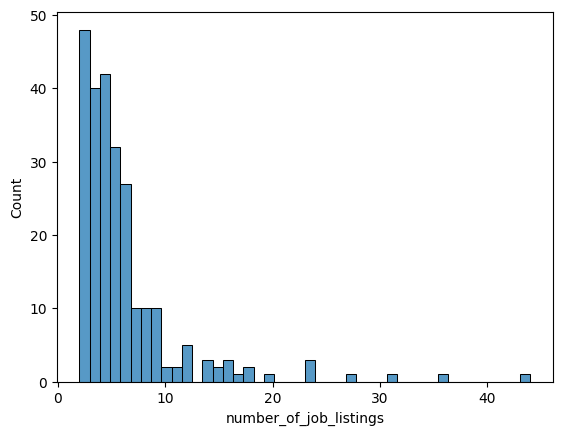

In [ ]:
import seaborn as sns

sns.histplot(result_df["number_of_job_listings"])

In [ ]:
result_df.loc[result_df["number_of_job_listings"] < 10].sort_values(
    "number_of_job_listings", ascending=False
).head()

,company,company_indeedUrl,lowest_company_offer,highest_company_offer,rating,reviewsCount,searchTerm,number_of_job_listings,oldest_posting_date
28,Xero,https://au.indeed.com/cmp/Xero,NaN,NaN,4.3,74,software engineer,9,2025-08-08 09:30:29.665
34,Tabcorp,https://au.indeed.com/cmp/Tabcorp-Holdings,NaN,NaN,3.8,70,software engineer,9,2025-07-28 07:30:56.765
37,InfoTrack,https://au.indeed.com/cmp/Infotrack,NaN,NaN,4.0,28,software engineer,9,2025-08-05 01:22:51.578
36,Thales,https://au.indeed.com/cmp/Thales,NaN,NaN,3.9,2814,software engineer,9,2025-08-04 04:08:03.024
35,Genius Sports Group,https://au.indeed.com/cmp/Genius-Sports,NaN,NaN,4.3,35,software engineer,9,2025-08-12 13:39:26.067


<Axes: xlabel='highest_company_offer', ylabel='Count'>

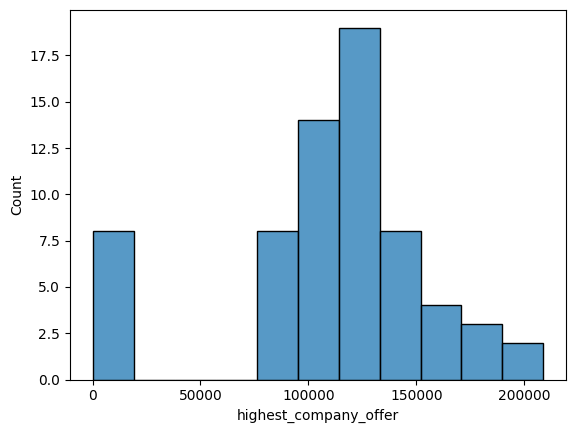

In [ ]:
import seaborn as sns

sns.histplot(result_df["highest_company_offer"])

<Axes: xlabel='lowest_company_offer', ylabel='Count'>

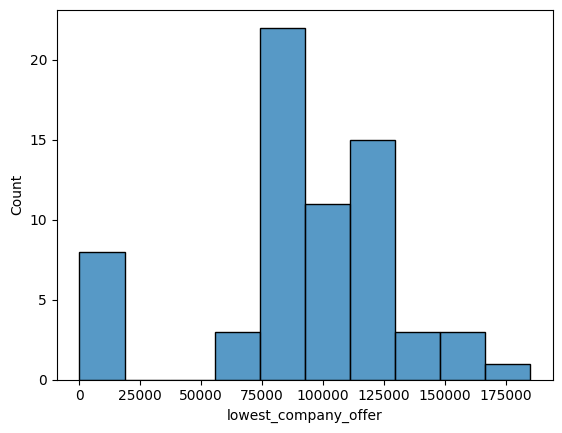

In [ ]:
import seaborn as sns

sns.histplot(result_df["lowest_company_offer"])

## What skills are in demand in the market? What are the salary brackets?

### data scientist/software engineer

In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
three_months_ago = latest_scraped_date - relativedelta(months=3)

target_keywords = ",".join([f"'{x}'" for x in data_tech_skills])

query = f"""
SELECT
    keywords.keyword,
    MIN(df_jobs.min_salary) AS min_salary_offered,
    MAX(df_jobs.max_salary) AS max_salary_offered,
    AVG((df_jobs.min_salary + df_jobs.max_salary) / 2.0) AS mean_salary_offered,
    MEDIAN((df_jobs.min_salary + df_jobs.max_salary) / 2.0) AS median_salary_offered,
    COUNT(df_jobs.id) AS number_of_job_listings
FROM keyword_job
JOIN df_jobs ON df_jobs.id = keyword_job.job_id
JOIN keywords ON keywords.id = keyword_job.keyword_id
JOIN df_companies on df_companies.company_indeedUrl = df_jobs.company_indeedUrl
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.postingDateParsed >= '{three_months_ago}'
  AND df_companies.country = 'AU'
GROUP BY keywords.keyword
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "keyword",
        "min_salary_offered",
        "max_salary_offered",
        "mean_salary_offered",
        "median_salary_offered",
        "number_of_job_listings",
    ],
)
result_df

,keyword,min_salary_offered,max_salary_offered,mean_salary_offered,median_salary_offered,number_of_job_listings
0,c++,30.0,208821.0,102658.966081,109976.00,382
1,r,30.0,208821.0,102658.966081,109976.00,382
2,java,30.0,200000.0,99592.647833,100000.00,164
3,sql,30.0,180000.0,101436.515370,109713.47,128
4,javascript,30.0,200000.0,93340.247045,91375.00,106
5,python,700.0,185000.0,109357.005238,95000.00,99
6,typescript,50.0,200000.0,97935.363636,120000.00,77
7,c#,10000.0,160000.0,102897.329000,109952.00,72
8,kotlin,100000.0,160000.0,126666.666667,130000.00,20
9,swift,100000.0,160000.0,125000.000000,125000.00,12


### customer support

In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
three_months_ago = latest_scraped_date - relativedelta(months=3)

target_keywords = ",".join([f"'{x}'" for x in call_center_software])

query = f"""
SELECT
    keywords.keyword,
    MIN(df_jobs.min_salary) AS min_salary_offered,
    MAX(df_jobs.max_salary) AS max_salary_offered,
    AVG((df_jobs.min_salary + df_jobs.max_salary) / 2.0) AS mean_salary_offered,
    MEDIAN((df_jobs.min_salary + df_jobs.max_salary) / 2.0) AS median_salary_offered,
    COUNT(df_jobs.id) AS number_of_job_listings
FROM keyword_job
JOIN df_jobs ON df_jobs.id = keyword_job.job_id
JOIN keywords ON keywords.id = keyword_job.keyword_id
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.postingDateParsed >= '{three_months_ago}'
  AND df_jobs.searchTerm = 'customer'
GROUP BY keywords.keyword
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "keyword",
        "min_salary_offered",
        "max_salary_offered",
        "mean_salary_offered",
        "median_salary_offered",
        "number_of_job_listings",
    ],
)
result_df

,keyword,min_salary_offered,max_salary_offered,mean_salary_offered,median_salary_offered,number_of_job_listings
0,zendesk,20000.0,35000.0,27666.666667,27500.0,12
1,google workspace,21000.0,21000.0,21000.000000,21000.0,7
2,microsoft excel,23000.0,40000.0,32333.333333,32500.0,4
3,freshdesk,20000.0,35000.0,27500.000000,27500.0,4
4,slack,695.0,28000.0,14347.500000,14347.5,3
5,five9,NaN,NaN,NaN,NaN,2
6,servicenow,NaN,NaN,NaN,NaN,1
7,zoho desk,NaN,NaN,NaN,NaN,1


## Typical lifetime of job listings in AU

In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
time_start = latest_scraped_date - relativedelta(months=1)
last_month = latest_scraped_date - relativedelta(months=1)

target_keywords = ",".join([f"'{x}'" for x in data_tech_skills])

query = f"""
SELECT
    df_companies.company,
    df_companies.company_indeedUrl,
    df_companies.lowest_company_offer,
    df_companies.highest_company_offer,
    df_companies.rating,
    df_companies.reviewsCount,
    df_jobs.searchTerm,
    COUNT(df_jobs.id) AS number_of_job_listings,
    MIN(df_jobs.postingDateParsed) AS oldest_posting_date,
    MIN(DATEDIFF('day', CAST(df_jobs.postingDateParsed AS TIMESTAMP), CAST(df_jobs.scrapedAt AS TIMESTAMP))) AS min_days_since_posting,
    MEDIAN(DATEDIFF('day', CAST(df_jobs.postingDateParsed AS TIMESTAMP), CAST(df_jobs.scrapedAt AS TIMESTAMP))) AS median_days_since_posting,
    AVG(DATEDIFF('day', CAST(df_jobs.postingDateParsed AS TIMESTAMP), CAST(df_jobs.scrapedAt AS TIMESTAMP))) AS mean_days_since_posting,
    MAX(DATEDIFF('day', CAST(df_jobs.postingDateParsed AS TIMESTAMP), CAST(df_jobs.scrapedAt AS TIMESTAMP))) AS max_days_since_posting,

FROM df_companies
JOIN df_jobs ON df_jobs.company_indeedUrl = df_companies.company_indeedUrl
JOIN keyword_job ON keyword_job.job_id = df_jobs.id
JOIN keywords ON keywords.id = keyword_job.keyword_id
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.scrapedAt >= '{last_month}'
  AND df_companies.country = 'AU'
GROUP BY df_companies.company,
        df_companies.company_indeedUrl,
        df_companies.lowest_company_offer,
        df_companies.highest_company_offer,
        df_companies.rating,
        df_companies.reviewsCount,
        df_jobs.searchTerm
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "company",
        "company_indeedUrl",
        "lowest_company_offer",
        "highest_company_offer",
        "rating",
        "reviewsCount",
        "searchTerm",
        "number_of_job_listings",
        "oldest_posting_date",
        "min_days_since_posting",
        "median_days_since_posting",
        "mean_days_since_posting",
        "max_days_since_posting",
    ],
)
result_df

,company,company_indeedUrl,lowest_company_offer,highest_company_offer,rating,reviewsCount,searchTerm,number_of_job_listings,oldest_posting_date,min_days_since_posting,median_days_since_posting,mean_days_since_posting,max_days_since_posting
0,Luxury Escapes,https://au.indeed.com/cmp/Luxury-Escapes,NaN,NaN,4.4,7,software engineer,44,2025-07-28 09:47:00.005,12,21.0,18.545455,21
1,Microsoft,https://au.indeed.com/cmp/Microsoft,NaN,NaN,4.2,8811,software engineer,36,2025-07-30 01:46:00.391,4,17.5,12.666667,19
2,Commonwealth Bank,https://au.indeed.com/cmp/Commonwealth-Bank-of-Australia-9607b3c5,NaN,NaN,3.9,812,software engineer,31,2025-07-28 06:50:01.697,3,11.0,10.903226,21
3,Deloitte,https://au.indeed.com/cmp/Deloitte,NaN,NaN,3.9,13875,software engineer,27,2025-08-06 12:02:52.317,3,6.0,5.851852,12
4,Accenture,https://au.indeed.com/cmp/Accenture,NaN,NaN,4.0,28061,software engineer,23,2025-07-29 16:46:06.241,6,19.0,14.565217,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,IMB Bank,https://au.indeed.com/cmp/Imb-Bank,NaN,NaN,3.9,11,software engineer,2,2025-08-09 11:37:15.560,9,9.0,9.000000,9
243,The Config Team,https://au.indeed.com/cmp/The-Config-Team,NaN,NaN,0.0,0,software engineer,2,2025-08-04 16:49:47.300,14,14.0,14.000000,14
244,ExeQution Analytics,https://au.indeed.com/cmp/Exeqution-Analytics,100000.0,150000.0,0.0,0,software engineer,2,2025-08-07 01:40:21.432,11,11.0,11.000000,11
245,XPT Software Australia Pty Ltd,https://au.indeed.com/cmp/Xpt-Software-Australia-Pty-Ltd,85000.0,165000.0,2.0,1,software engineer,2,2025-08-06 06:41:43.878,12,12.0,12.000000,12


# Sample query. Jobs that mention python

In [ ]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Luxury Escapes,https://au.indeed.com/cmp/Luxury-Escapes,NaN,NaN,4.4,7,software engineer,44,2025-07-28 09:47:00.005,12,21.0,18.545455,21
1,Microsoft,https://au.indeed.com/cmp/Microsoft,NaN,NaN,4.2,8811,software engineer,36,2025-07-30 01:46:00.391,4,17.5,12.666667,19
2,Commonwealth Bank,https://au.indeed.com/cmp/Commonwealth-Bank-of-Australia-9607b3c5,NaN,NaN,3.9,812,software engineer,31,2025-07-28 06:50:01.697,3,11.0,10.903226,21
3,Deloitte,https://au.indeed.com/cmp/Deloitte,NaN,NaN,3.9,13875,software engineer,27,2025-08-06 12:02:52.317,3,6.0,5.851852,12
4,Accenture,https://au.indeed.com/cmp/Accenture,NaN,NaN,4.0,28061,software engineer,23,2025-07-29 16:46:06.241,6,19.0,14.565217,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,IMB Bank,https://au.indeed.com/cmp/Imb-Bank,NaN,NaN,3.9,11,software engineer,2,2025-08-09 11:37:15.560,9,9.0,9.000000,9
243,The Config Team,https://au.indeed.com/cmp/The-Config-Team,NaN,NaN,0.0,0,software engineer,2,2025-08-04 16:49:47.300,14,14.0,14.000000,14
244,ExeQution Analytics,https://au.indeed.com/cmp/Exeqution-Analytics,100000.0,150000.0,0.0,0,software engineer,2,2025-08-07 01:40:21.432,11,11.0,11.000000,11
245,XPT Software Australia Pty Ltd,https://au.indeed.com/cmp/Xpt-Software-Australia-Pty-Ltd,85000.0,165000.0,2.0,1,software engineer,2,2025-08-06 06:41:43.878,12,12.0,12.000000,12


In [ ]:
df_jobs.loc[df_jobs["description"].str.lower().str.contains("python")]

,positionName,id,min_salary,max_salary,postingDateParsed,monthPosted,scrapedAt,latestScrapedDate,company,company_url,company_indeedUrl,company_size_min,company_size_max,rating,reviewsCount,description,<30d,<60d,<90d,searchTerm,country
3,Software Development Engineer,1f90faf828ed5180,NaN,NaN,2025-04-07 16:45:53.444,25-04,2025-04-08T04:09:56.248Z,2025-08-18 05:46:56.638,Accenture,https://www.accenture.com,https://ph.indeed.com/cmp/Accenture,NaN,NaN,4.0,27672,"Analyze, design, code and test multiple components of application code across one or more client...",False,False,False,software engineer,PH
4,Full Stack Developer,f25208784d712558,80000.0,140000.0,2025-04-07 22:08:32.327,25-04,2025-04-08T04:09:53.860Z,2025-08-18 05:46:56.638,My Biz Niche,None,https://ph.indeed.com/cmp/My-Biz-Niche,NaN,NaN,4.0,4,"_Web Services Department | Full-Time | Remote_\n\n*Ready to build fast, secure, and scalable web...",False,False,False,software engineer,PH
7,Full Stack Developer,cb375daa345a199c,NaN,NaN,2025-04-07 20:50:05.204,25-04,2025-04-08T04:09:53.230Z,2025-08-18 05:46:56.638,ShortPoint,None,https://ph.indeed.com/cmp/Shortpoint,NaN,NaN,0.0,0,We are seeking a talented and motivated Fullstack Developer to join our growing team. This is an...,False,False,False,software engineer,PH
12,AI Developer,ebc57ca0af1b5cb3,NaN,NaN,2025-04-07 14:10:57.506,25-04,2025-04-08T04:09:46.804Z,2025-08-18 05:46:56.638,RELX,https://www.lexisnexis.com,https://ph.indeed.com/cmp/Relx-Group,NaN,NaN,3.8,128,"As an AI Developer, you will design, develop, and deploy AI models and solutions, working closel...",False,False,False,software engineer,PH
13,DevOps Engineer - AWS (WORK FROM HOME),060e521f4ce3469e,NaN,NaN,2025-04-07 13:58:07.479,25-04,2025-04-08T04:09:46.434Z,2025-08-18 05:46:56.638,PeoplePlusTech Inc.,None,https://ph.indeed.com/cmp/Peopleplustech-Inc.-5,NaN,NaN,0.0,0,*Job Title: *_*AWS DEVOPS SENIOR ENGINEER*_\n\n*Work Set Up: *_*Remote / Work from home*_\n\n*Sh...,False,False,False,software engineer,PH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,Cloud DevOps Engineer,6e67d227d185eb37,NaN,NaN,2025-07-29 12:10:50.417,25-07,2025-08-18T05:46:53.165Z,2025-08-18 05:46:56.638,GBST,https://www.gbst.com/,https://au.indeed.com/cmp/Gbst,501.0,1000.0,3.7,3,Posted: 29/07/2025\nClosing Date: 29/08/2025\nJob Type: Permanent - Full Time\nLocation: Sydney\...,True,True,True,software engineer,AU
373,Senior Software Engineer,1e51264df2b8d105,NaN,NaN,2025-07-29 00:33:30.058,25-07,2025-08-18T05:46:51.909Z,2025-08-18 05:46:56.638,Carbiz Rentals,None,https://au.indeed.com/cmp/Carbiz-Rentals,NaN,NaN,0.0,0,"Are you passionate about turning cutting-edge computer vision and AI research into delightful, r...",True,True,True,software engineer,AU
375,Senior Security Automation Engineer,e1a8c71f1c62f5c0,NaN,NaN,2025-07-29 10:34:36.292,25-07,2025-08-18T05:46:56.638Z,2025-08-18 05:46:56.638,Coles Group,https://www.colescareers.com.au,https://au.indeed.com/cmp/Coles-Group-4,10000.0,NaN,3.6,3952,We've been trusted to serve Aussie communities since 1914 and grown to become a top 30-listed on...,True,True,True,software engineer,AU
376,DevOps Engineer,d1889a764b2e2932,NaN,NaN,2025-07-28 13:33:06.693,25-07,2025-08-18T05:46:54.791Z,2025-08-18 05:46:56.638,Verra Mobility,http://www.verramobility.com,https://au.indeed.com/cmp/Verra-Mobility,1001.0,5000.0,2.7,100,Verra Mobility is a global leader in smart mobility. We develop technology-driven solutions to m...,True,True,True,software engineer,AU


In [ ]:
len(con.execute("SELECT * FROM keyword_job").fetchall())

19148

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# -------------------------
# Function 1: Topic Discovery
# -------------------------
def extract_topics(text_series: pd.Series, top_n: int = 10):
    """
    Discover topics from a Pandas Series of long texts using BERTopic.

    Args:
        text_series (pd.Series): Series of texts.
        top_n (int): Number of top topics to return.

    Returns:
        List[str]: Top-N discovered topic descriptions.
    """
    docs = text_series.dropna().tolist()
    topic_model = BERTopic(vectorizer_model=CountVectorizer(stop_words="english"))
    topics, _ = topic_model.fit_transform(docs)
    topic_info = topic_model.get_topic_info()

    top_topics = []
    for _, row in topic_info.head(top_n).iterrows():
        words = ", ".join([w for w, _ in topic_model.get_topic(row.Topic)])
        top_topics.append(f"Topic {row.Topic}: {words}")

    return top_topics


# -------------------------
# Function 2: Word2Vec Visualization
# -------------------------
def visualize_word2vec(
    text_series: pd.Series, vector_size: int = 100, min_count: int = 5
):
    """
    Train a Word2Vec model on the dataset and visualize embeddings using t-SNE.

    Args:
        text_series (pd.Series): Series of texts.
        vector_size (int): Word2Vec vector dimension.
        min_count (int): Minimum frequency for words to be included.
    """
    # Tokenize (very simple, you may want to use spaCy or NLTK for better tokenization)
    tokenized = [str(doc).lower().split() for doc in text_series.dropna()]

    # Train Word2Vec
    w2v_model = Word2Vec(
        sentences=tokenized,
        vector_size=vector_size,
        window=5,
        min_count=min_count,
        workers=4,
    )

    # Extract word vectors
    words = list(w2v_model.wv.index_to_key)
    X = w2v_model.wv[words]

    # Reduce dimensions for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)

    for i, word in enumerate(words[:200]):  # only label top 200 words to avoid clutter
        plt.annotate(word, (X_tsne[i, 0], X_tsne[i, 1]))

    plt.title("Word2Vec Embeddings Visualization (t-SNE)")
    plt.show()

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# Query + unsupervised topic analysis;

In [ ]:
df_jobs
search = df_jobs.loc[
    (df_jobs["country"] == "PH") & (df_jobs["searchTerm"] == "software engineer")
]
print(len(search))
search.head()

3446


,positionName,id,min_salary,max_salary,postingDateParsed,monthPosted,scrapedAt,latestScrapedDate,company,company_url,company_indeedUrl,company_size_min,company_size_max,rating,reviewsCount,description,<30d,<60d,<90d,searchTerm,country
0,BI Developer,d17ed418472b107e,NaN,NaN,2025-04-08 01:12:13.755,25-04,2025-04-08T04:09:36.739Z,2025-08-18 05:46:56.638,People Matter PH,None,https://ph.indeed.com/cmp/People-Matter-Ph,NaN,NaN,0.0,0,This is a full-time role for a BI Developer (ONSITE) Early Dayshift at PeopleMatter PH.\n\nThe B...,False,False,False,software engineer,PH
1,Software Engineer,aff69509c9cfe3b6,NaN,NaN,2025-04-07 16:35:16.115,25-04,2025-04-08T04:09:56.428Z,2025-08-18 05:46:56.638,Finastra USA Corporation,https://finastra.com/,https://ph.indeed.com/cmp/Finastra,NaN,NaN,3.4,310,Responsibilities:\nJob Description\nWe’re looking for a software engineer with 3+ years of exper...,False,False,False,software engineer,PH
2,Jr. PHP Developer (LAMP Stack),850eb6521c2b46e6,NaN,NaN,2025-04-08 01:42:58.534,25-04,2025-04-08T04:09:57.638Z,2025-08-18 05:46:56.638,H2 Software Consulting Services Inc.,None,https://ph.indeed.com/cmp/H2-Software-Consulting-Services-Inc.-2,NaN,NaN,3.3,21,We are seeking a motivated and enthusiastic *Junior PHP Developer* to join our growing developme...,False,False,False,software engineer,PH
3,Software Development Engineer,1f90faf828ed5180,NaN,NaN,2025-04-07 16:45:53.444,25-04,2025-04-08T04:09:56.248Z,2025-08-18 05:46:56.638,Accenture,https://www.accenture.com,https://ph.indeed.com/cmp/Accenture,NaN,NaN,4.0,27672,"Analyze, design, code and test multiple components of application code across one or more client...",False,False,False,software engineer,PH
4,Full Stack Developer,f25208784d712558,80000.0,140000.0,2025-04-07 22:08:32.327,25-04,2025-04-08T04:09:53.860Z,2025-08-18 05:46:56.638,My Biz Niche,None,https://ph.indeed.com/cmp/My-Biz-Niche,NaN,NaN,4.0,4,"_Web Services Department | Full-Time | Remote_\n\n*Ready to build fast, secure, and scalable web...",False,False,False,software engineer,PH


In [ ]:
%%time
topics = extract_topics(search["description"].sample(frac=1))
print("Discovered topics:")
topics

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Discovered topics:
CPU times: user 7min 14s, sys: 37.4 s, total: 7min 52s
Wall time: 7min 51s


['Topic -1: experience, work, development, pay, software, team, years, job, skills, shift',
 'Topic 0: software, development, technical, project, programming, code, team, design, requirements, skills',
 'Topic 1: cloud, infrastructure, azure, devops, security, aws, network, monitoring, tools, experience',
 'Topic 2: frontend, react, reactjs, nodejs, backend, typescript, experience, work, web, development',
 'Topic 3: wordpress, website, websites, web, content, seo, design, marketing, responsive, experience',
 'Topic 4: test, testing, automation, automated, quality, qa, software, selenium, manual, cases',
 'Topic 5: java, spring, boot, experience, code, design, applications, using, maven, developer',
 'Topic 6: data, bi, power, reporting, reports, dashboards, business, sql, tableau, etl',
 'Topic 7: laravel, php, work, web, development, experience, pay, shift, mysql, job',
 'Topic 8: oracle, application, opentext, technical, provide, business, exstream, support, hcm, requirements']

In [ ]:
%%time
topics = extract_topics(result_df_descs_ph["description"].sample(frac=1))
print("Discovered topics:")
topics

NameError: name 'result_df_descs_ph' is not defined

In [ ]:
%%time
topics = extract_topics(
    result_df_descs_ph.loc[result_df_descs_ph["searchTerm"] == "software engineer"][
        "description"
    ].sample(frac=1)
)
print("Discovered topics:")
topics

NameError: name 'result_df_descs_ph' is not defined

In [ ]:
pd.set_option("display.max_colwidth", 100)
from datetime import datetime
from dateutil.relativedelta import relativedelta

latest_scraped_date = df_jobs["latestScrapedDate"].iloc[0]
time_start = latest_scraped_date - relativedelta(months=1)
last_month = latest_scraped_date - relativedelta(months=1)

target_keywords = ",".join([f"'{x}'" for x in data_tech_skills])

query = f"""
SELECT
    df_companies.company,
    df_companies.company_indeedUrl,
    df_companies.lowest_company_offer,
    df_companies.highest_company_offer,
    df_companies.rating,
    df_companies.reviewsCount,
    df_jobs.searchTerm,
    COUNT(df_jobs.id) AS number_of_job_listings,
    MIN(df_jobs.postingDateParsed) AS oldest_posting_date,

    LIST(
        {{
            'positionName': df_jobs.positionName,
            'id': df_jobs.id,
            'min_salary': df_jobs.min_salary,
            'max_salary': df_jobs.max_salary,
            'postingDateParsed': df_jobs.postingDateParsed,
            'scrapedAt': df_jobs.scrapedAt,
            'description': df_jobs.description
        }}
    ) AS jobs
FROM df_companies
JOIN df_jobs ON df_jobs.company_indeedUrl = df_companies.company_indeedUrl
JOIN keyword_job ON keyword_job.job_id = df_jobs.id
JOIN keywords ON keywords.id = keyword_job.keyword_id
WHERE keywords.keyword IN ({target_keywords})
  AND df_jobs.scrapedAt >= '{last_month}'
  AND df_companies.country = 'AU'
GROUP BY df_companies.company,
        df_companies.company_indeedUrl,
        df_companies.lowest_company_offer,
        df_companies.highest_company_offer,
        df_companies.rating,
        df_companies.reviewsCount,
        df_jobs.searchTerm
ORDER BY number_of_job_listings DESC;
"""
result = con.execute(query).fetchall()
result_df = pd.DataFrame(
    result,
    columns=[
        "company",
        "company_indeedUrl",
        "lowest_company_offer",
        "highest_company_offer",
        "rating",
        "reviewsCount",
        "searchTerm",
        "number_of_job_listings",
        "oldest_posting_date",
        "jobs",
    ],
)
result_df
result_df_descs = pd.json_normalize(result_df.explode("jobs")["jobs"])
result_df_descs

,positionName,id,min_salary,max_salary,postingDateParsed,scrapedAt,description
0,Frontend Engineer - Design System,915d6000945ab432,NaN,NaN,2025-08-06 03:46:32.847,2025-08-18T05:45:44.476Z,Be part of the team transforming global travel experiences!\n\nLuxury Escapes is one of the worl...
1,Principal Frontend Engineer,28b7621cd8c53e9c,NaN,NaN,2025-08-06 03:46:31.530,2025-08-18T05:45:53.256Z,Be part of the team transforming global travel experiences!\n\nLuxury Escapes is one of the worl...
2,Mid-level Software Engineer,fb0c3e9bf5e393f1,NaN,NaN,2025-07-28 09:47:00.005,2025-08-18T05:46:20.662Z,Be part of the team transforming global travel experiences!\n\nLuxury Escapes is one of the worl...
3,Senior Software Engineer,89e8d2ed9ea12c4e,NaN,NaN,2025-07-28 09:47:02.125,2025-08-18T05:46:45.986Z,Be part of the team transforming global travel experiences!\n\nLuxury Escapes is one of the worl...
4,Principal Backend Engineer,bd4a375664db3357,NaN,NaN,2025-07-28 09:47:01.968,2025-08-18T05:46:52.019Z,Help shape the future of global travel technology.\n\nLuxury Escapes is one of the world’s faste...
...,...,...,...,...,...,...,...
1443,Software Engineer – KDB+/q Specialist,61277d6c9b6adb82,100000.0,150000.0,2025-08-07 01:40:21.432,2025-08-18T05:46:16.808Z,ExeQution Analytics is seeking a highly skilled Software Engineer with deep expertise in KDB+/q ...
1444,Project Technical Lead,0d2781c3767c60c8,85000.0,165000.0,2025-08-06 06:41:43.878,2025-08-18T05:46:39.001Z,*The Role:*\n\n7+ years exp as Project Technical Lead\n\n* Multiple positions for permanent role...
1445,Project Technical Lead,0d2781c3767c60c8,85000.0,165000.0,2025-08-06 06:41:43.878,2025-08-18T05:46:39.001Z,*The Role:*\n\n7+ years exp as Project Technical Lead\n\n* Multiple positions for permanent role...
1446,Senior Software Developer C++,1e1dab540d51b224,NaN,NaN,2025-07-29 03:46:55.235,2025-08-18T05:46:52.377Z,"An established business, operating for 38 years, with offices globally.\nAn enjoyable team cultu..."


In [ ]:
%%time
# Example text dataset
texts = pd.Series(
    [
        "I love machine learning and natural language processing",
        "Deep learning is great for image recognition",
        "Topic modeling helps discover themes in text data",
        "Word embeddings represent words in vector space",
    ]
)

topics = extract_topics(result_df_descs["description"].sample(frac=1))
print("Discovered topics:")
topics

Discovered topics:
CPU times: user 3min 10s, sys: 20.8 s, total: 3min 31s
Wall time: 3min 38s


['Topic -1: software, experience, development, requirements, data, technical, working, work, application, afp',
 'Topic 0: boeing, defence, research, opportunity, quantum, software, program, programs, security, innovative',
 'Topic 1: macquarie, leave, trading, wide, data, including, paid, access, markets, reimbursement',
 'Topic 2: fujitsu, aroflo, simpro, knowledge, people, development, server, solutions, net, azure',
 'Topic 3: aws, services, cloud, amazon, customers, professional, imed, engagements, verra, imaging',
 'Topic 4: jetstar, software, takeoff, mining, drilling, monitoring, operations, infrastructure, tools, emesent',
 'Topic 5: safetyculture, robotics, hammertech, abi, construction, team, software, engineering, rust, distributed',
 'Topic 6: sports, teamworks, tennis, athletic, gaming, performance, jd, crm, genius, art',
 'Topic 7: spring, ust, boot, using, java, saab, integration, expertise, experience, cognizant',
 'Topic 8: leidos, nasdaq, amp, engineering, feedback, 

In [ ]:
topics[3]

'Topic 2: fujitsu, aroflo, simpro, knowledge, people, development, server, solutions, net, azure'

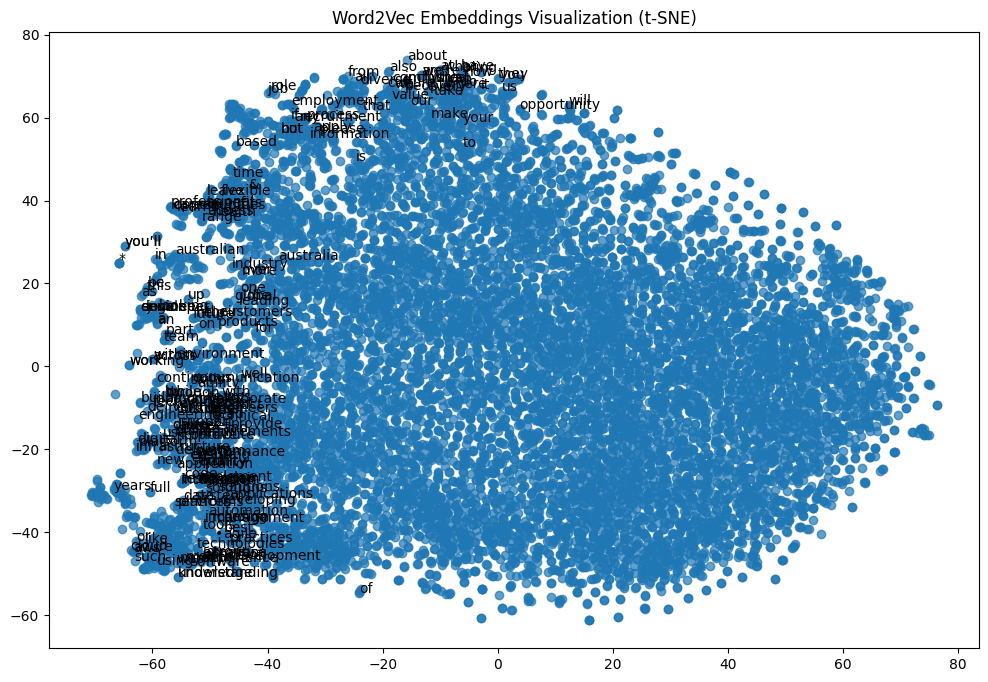

In [ ]:
visualize_word2vec(result_df_descs["description"].sample(frac=1))

In [ ]:
!pip install --upgrade gspread gspread-dataframe

In [ ]:
import gspread
from google.colab import auth

auth.authenticate_user()

from google.auth import default

creds, _ = default()

gc = gspread.authorize(creds)

KeyboardInterrupt: 

In [ ]:
try:
    spreadsheet = gc.open("JobMarketCrawler")
    print("a")
except gspread.SpreadsheetNotFound:
    spreadsheet = gc.create("JobMarketCrawler")
    print("b")
worksheet = spreadsheet.sheet1

# Upload to gsheets

In [ ]:
from gspread_dataframe import set_with_dataframe, get_as_dataframe

# Suppose your DataFrame is called df_filtered
existing_df = get_as_dataframe(worksheet).rename(columns={"company": "company"})

# Check if the existing_df is empty or if the columns are different
if existing_df.empty or list(existing_df.columns) != list(companies_only_df.columns):
    # If empty or columns are different, upload the entire DataFrame
    set_with_dataframe(worksheet, companies_only_df)
else:
    # Identify new rows in companies_only_df that are not in existing_df
    # This assumes that the combination of columns uniquely identifies a row
    merged_df = companies_only_df.merge(
        existing_df[["indeedUrl", "company"]], on="indeedUrl", how="left"
    )
    new_rows_df = (
        merged_df.loc[pd.isnull(merged_df["company_y"])]
        .copy()
        .rename(columns={"company_x": "company"})
        .drop(columns=["company_y"])
    )
    if not new_rows_df.empty:
        # Append only the new rows to the existing sheet
        set_with_dataframe(
            worksheet,
            new_rows_df,
            row=len(existing_df) + 2,
            include_column_header=False,
        )
        print("uploaded")
        display(new_rows_df)
    else:
        print("No new rows to upload.")

# PostLabel

In [ ]:
from gspread_dataframe import get_as_dataframe

# Read back into Colab (with notes)
df_updated = get_as_dataframe(worksheet)
df_updated = df_updated.loc[df_updated["like"] != 0].copy()
df_updated

# Save to drive

In [88]:
from datetime import datetime
import os

# Generate a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the timestamped directory
output_dir = f"/content/drive/MyDrive/Datasets/jobs/processed/{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# Save df_jobs
df_jobs.to_parquet(os.path.join(output_dir, "df_jobs.parquet"))
print(f"df_jobs saved to {os.path.join(output_dir, 'df_jobs.parquet')}")

# Save df_companies
df_companies.to_parquet(os.path.join(output_dir, "df_companies.parquet"))
print(f"df_companies saved to {os.path.join(output_dir, 'df_companies.parquet')}")

# Save keywords table
keywords_df = con.execute("SELECT * FROM keywords").fetchdf()
keywords_df.to_parquet(os.path.join(output_dir, "keywords.parquet"))
print(f"keywords table saved to {os.path.join(output_dir, 'keywords.parquet')}")

# Save keyword_job table
keyword_job_df = con.execute("SELECT * FROM keyword_job").fetchdf()
keyword_job_df.to_parquet(os.path.join(output_dir, "keyword_job.parquet"))
print(f"keyword_job table saved to {os.path.join(output_dir, 'keyword_job.parquet')}")

# Save result_df
result_df.to_parquet(os.path.join(output_dir, "result_df.parquet"))
print(f"result_df saved to {os.path.join(output_dir, 'result_df.parquet')}")

df_jobs saved to /content/drive/MyDrive/Datasets/jobs/processed/20250829_064001/df_jobs.parquet
df_companies saved to /content/drive/MyDrive/Datasets/jobs/processed/20250829_064001/df_companies.parquet
keywords table saved to /content/drive/MyDrive/Datasets/jobs/processed/20250829_064001/keywords.parquet
keyword_job table saved to /content/drive/MyDrive/Datasets/jobs/processed/20250829_064001/keyword_job.parquet
result_df saved to /content/drive/MyDrive/Datasets/jobs/processed/20250829_064001/result_df.parquet


In [89]:
import os

# Create the directory for markdown files
markdown_output_dir = os.path.join(output_dir, "markdown_companies")
os.makedirs(markdown_output_dir, exist_ok=True)

# Iterate through the result_df and create a markdown file for each row
for index, row in result_df.iterrows():
    # Create a filename based on the company name (replace invalid characters)
    filename = (
        f"{row['company'].replace('/', '_').replace(':', '_').replace('|', '_')}.md"
    )
    filepath = os.path.join(markdown_output_dir, filename)

    with open(filepath, "w", encoding="utf-8") as f:
        # Write Obsidian properties
        f.write("---\n")
        for col in result_df.head().columns:
            # Handle list columns separately for better readability in properties
            if col == "jobs":
                job_titles = [job["positionName"] for job in row[col]]
                f.write(f"{col}: {job_titles}\n")
            elif col == "all_keywords_mentioned":
                # Format all_keywords_mentioned as tags
                tags_list = [
                    f"#{keyword.replace(' ', '-').replace('+','_plus_')}"
                    for keyword in row[col]
                ]
                tags = " ".join(tags_list)
                f.write(f"{col}: {tags_list}\n")
            else:
                f.write(f"{col}: {row[col]}\n")

        f.write(
            f"search_term: {row.get('jobs', [{'searchTerm': 'NA'}])[0]['searchTerm']}\n"
        )
        f.write("\n\n---\n\n")
        f.write(tags or "" + "\n")
        # Intro
        f.write(f"\n\n# 🌐Company name: {row['company']}\n\n")
        f.write(f"## 🤔 How should you approach this company?\n")
        job_titles = [job["positionName"] for job in row["jobs"]]
        prompt = f"You are a consultant helping me land a job at the company and you found me this lead. They have {row['listings_<30d']} listings in the last 30 days. Their job listings include: {job_titles}. Their job listings mention the following keywords: {row['all_keywords_mentioned']}".strip().replace(
            "  ", " "
        )
        f.write(f"You may try using this prompt:\n\n```\n{prompt}\n```\n")

        f.write(f"\n## 📒 Personal notes\n")

        if row["jobs"]:
            job_means = []
            for job in row["jobs"]:
                if job["min_salary"] and job["max_salary"]:
                    mean_salary = (job["min_salary"] + job["max_salary"]) / 2
                    job_means.append(mean_salary)

            if job_means:
                num_bins = min(7, len(job_means))

                hist, bin_edges = np.histogram(job_means, bins=num_bins)

                labels = [
                    f"{int(bin_edges[i])}-{int(bin_edges[i+1])}"
                    for i in range(len(bin_edges) - 1)
                ]
                data = hist.tolist()

                f.write("\n## 📊 Salary Histogram\n\n")
                f.write("```chart\n")
                f.write("type: bar\n")
                f.write(f"labels: {labels}\n")
                f.write("series:\n")
                f.write("  - title: Avg Salary\n")
                f.write(f"    data: {data}\n")
                f.write("```\n\n")

        # Optionally, add some content to the markdown file (e.g., job descriptions)
        f.write("\n\n## 💼 Job Listings:\n\n")
        if row["jobs"]:
            for job in row["jobs"]:
                f.write(f"### {job['positionName']}\n")
                f.write(f"**ID:** {job['id']}\n")
                f.write(f"**Salary:** {job['min_salary']} - {job['max_salary']}\n")
                f.write(f"**Posted:** {job['postingDateParsed']}\n")
                f.write(f"**Scraped:** {job['scrapedAt']}\n")
                f.write(f"**Search Term:** {job['searchTerm']}\n")
                f.write(f"**Country:** {job['country']}\n")
                # Include job-specific keywords as tags
                if job["keywords"]:
                    job_tags = " ".join(
                        [
                            f"#{keyword.replace(' ', '-').replace('+','_plus_')}"
                            for keyword in job["keywords"]
                        ]
                    )
                    f.write(f"**Keywords:** {job_tags}\n")
                f.write("#### Description:\n")
                f.write(f"{job['description']}\n\n")
        else:
            f.write("No job listings found.\n\n")


print(f"Markdown files saved to {markdown_output_dir}")

Markdown files saved to /content/drive/MyDrive/Datasets/jobs/processed/20250829_064001/markdown_companies
